In [1]:
import os
import json
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.pyplot as plt
from predicting_forest_fires.delta.setup import get_spark_session
from predicting_forest_fires.data.custom import (
    load_trained_model_and_test_data,
    load_trained_model_by_name_stage_version,
    model_prediction,
    model_confusion_matrix,
    model_classification_report,
)
from predicting_forest_fires.config.config import (
    DELTA_TEST_PATH,
    CONFUSION_MATRIX,
    MODEL_EVALUATION_REPORT,
)


In [3]:
mlflow.set_experiment("Forest Fire Prediction: Model Evaluation")
mlflow.set_tracking_uri("http://127.0.0.1:5000")
spark = get_spark_session()

logistic_regression_model = load_trained_model_by_name_stage_version()
decision_tree_model = load_trained_model_by_name_stage_version()
random_forest_model = load_trained_model_by_name_stage_version()
mlp_model = load_trained_model_by_name_stage_version()
spark_data = spark.read.format("delta").load(DELTA_TEST_PATH)
test_data: pd.DataFrame = spark_data.toPandas()

In [4]:
target = "area"
features = test_data.columns[test_data.columns != target]
X_test = test_data[features]
y_test = test_data[target]

In [5]:
model_predictions = {
    "Logistic Regression Classifier": model_prediction(logistic_regression_model, X_test),
    "Decision Tree Classifier": model_prediction(decision_tree_model, X_test),
    "Random Forest Classifier": model_prediction(random_forest_model, X_test),
    "MLP Classifier": model_prediction(mlp_model, X_test),
}

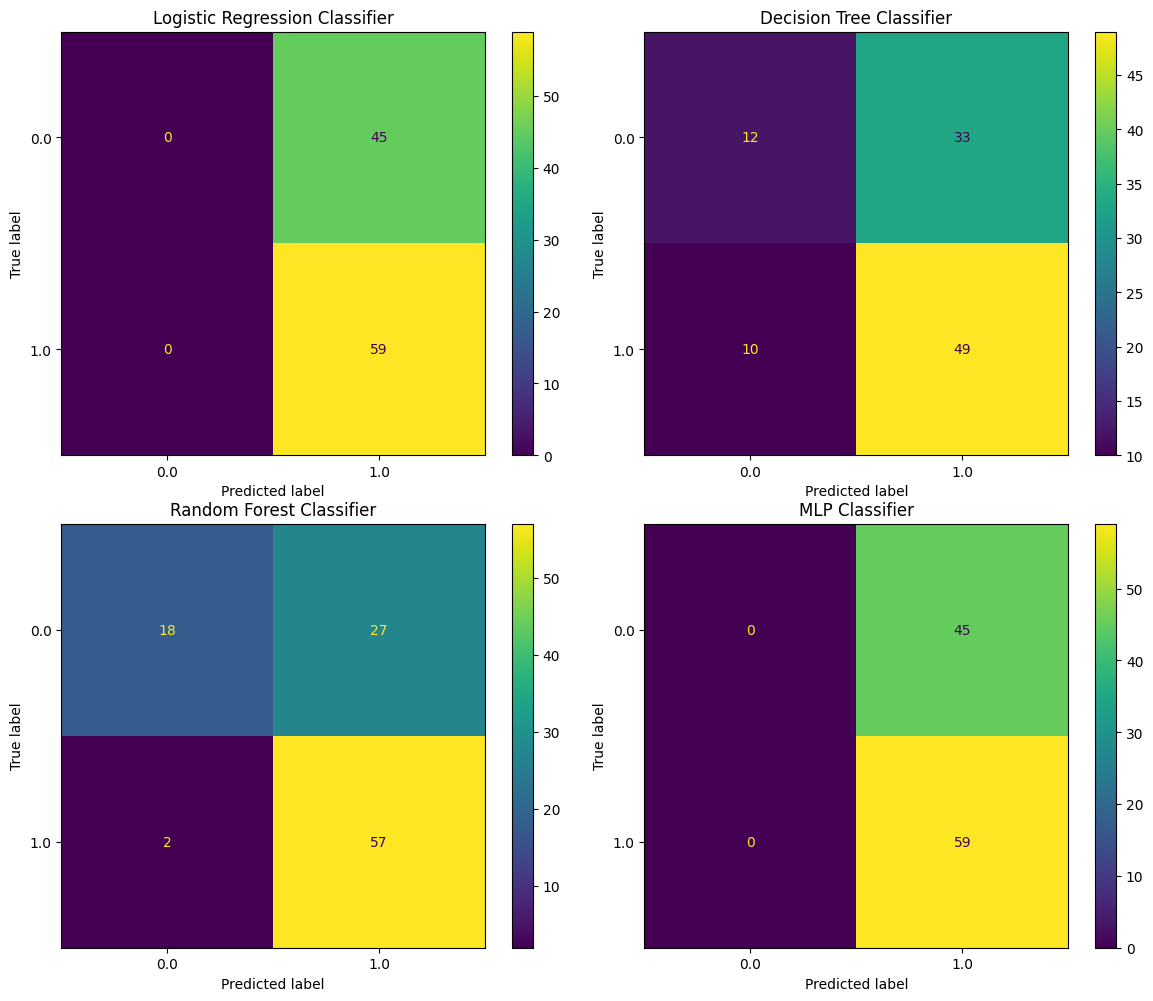

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i, (model_name, y_pred) in enumerate(model_predictions.items()):
    model = [
        logistic_regression_model,
        decision_tree_model,
        random_forest_model,
        mlp_model,
    ][i]
    model_confusion_matrix(model, y_test, y_pred, ax=axes[i])
    axes[i].set_title(model_name)

plt.tight_layout()
plt.show()

In [7]:
model_evaluation_report = model_classification_report(model_predictions, y_test)
model_evaluation_report

/Users/josephobukofe/Library/Caches/pypoetry/virtualenvs/predicting-forest-fires-i3PHmrBX-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/josephobukofe/Library/Caches/pypoetry/virtualenvs/predicting-forest-fires-i3PHmrBX-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/josephobukofe/Library/Caches/pypoetry/virtualenvs/predicting-forest-fires-i3PHmrBX-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Pre

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score
0,Logistic Regression Classifier,0.567308,0.567308,1.000000,0.723926
1,Decision Tree Classifier,0.586538,0.597561,0.830508,0.695035
2,Random Forest Classifier,0.721154,0.678571,0.966102,0.797203
3,MLP Classifier,0.567308,0.567308,1.000000,0.723926
